In [282]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import  WordNetLemmatizer
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import norm

import math

nltk.download('vader_lexicon')
nltk.download('punkt')

## try to use LDA model to find out 
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import TfidfModel

from sklearn.decomposition import NMF
from gensim.matutils import corpus2csc

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import IPython

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/bingjinliu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bingjinliu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The reddit posts and comments are stored in two different csv. 
First, we import data.

In [283]:
## posts
columns = ['post_id', 'post_flair', 'post_title', 'post_date',
       'post_url', 'post_body', 'post_down_votes', 'post_up_votes',
       'post_score', 'post_commentaries_count', 'post_cross_count',
       'post_awards_count']
posts_df = pd.read_csv('Posts.csv',sep = ';',index_col='post_id',usecols= columns)
posts_df.head()

## comments
columns = ['comment_post_id','comment_author','comment_date','comment_body','comment_score','comment_up_votes','comment_down_votes','comment_replies_count','comment_awards_count','comment_controversiality']
comments_df = pd.read_csv('Comments.csv',sep = ';', usecols=columns)
comments_df.head()

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,comment_post_id,comment_author,comment_date,comment_body,comment_score,comment_up_votes,comment_down_votes,comment_replies_count,comment_awards_count,comment_controversiality
0,idqwwi,t2_2hnv8ktm,2020-08-21,LMFAO!!! I am one of those guys who have the R...,2,2,0,0,0,0
1,idqwwi,t2_33sm1qon,2020-08-21,"Thats very humbling, Thank You!",1,1,0,0,0,0
2,idqwwi,t2_33sm1qon,2020-08-21,I basically purchased some led strips and glue...,2,2,0,0,0,0
3,idqwwi,t2_33sm1qon,2020-08-21,Lets just say me and Dex didnt end on good ter...,1,1,0,0,0,0
4,idqwwi,t2_33sm1qon,2020-08-21,its a mod for PC only...gives a more irl exper...,3,3,0,0,0,0


We plan to group these posts according to theirs topics, and conduct sentiment analysis on posts of different topics.
There are some posts which have few up votes. It means that these posts are not as influential as other posts with higher up votes. So we will delete these posts.

Also we only keep the columns we are interested in.

In [304]:
## refine posts and comments

def refine_post(posts_df, comments_df = comments_df, votes_threshold = 0.03, comments_threshold = 0.03):
    df = posts_df.copy()

    ## drop useless columns
    drop_cols = {'post_down_votes','post_score','post_cross_count'}.intersection(df.columns)
    # print(drop_cols)
    if len(drop_cols) != 0:
        df = df.drop(list(drop_cols), axis = 1)

    ## update the comments_number for each post
    for post in posts_df.index:        
        num_comments = len(comments_df[comments_df['comment_post_id'] == post].index)
        df.loc[post,'post_commentaries_count'] = num_comments        
        
    ## use post_up_votes threshold and commentaries_count threshold to refine post
    if (votes_threshold > 0) & (comments_threshold >0) :
        n = len(df.index)
        threshold1 = df['post_up_votes'].sort_values(ascending = True).iloc[math.floor(n*votes_threshold)]
        threshold2 = df['post_commentaries_count'].sort_values(ascending = True).iloc[math.floor(n*comments_threshold)]
        
    return df[(df['post_up_votes'] >= threshold1) & (df['post_commentaries_count'] >= threshold2)]



def refine_comments(comments_df, posts_df = posts_df,  votes_threshold = 1, comments_len = 15):
         
        ## first update the index with new post_df
        refined_posts = posts_df.index
        df = comments_df[comments_df['comment_post_id'].isin(list(refined_posts))]
        # print(len(df))
        ## drop some useless columns 
        drop_cols = {'comment_down_votes','comment_awards_count','comment_controversiality','comment_score'}.intersection(df.columns)
        # print(drop_cols)
        if len(drop_cols) != 0:
            df = df.drop(list(drop_cols), axis = 1)
        
        ## drop the null elemtents in comments_df, there are only 9 of them.
        df = df.dropna()
        # print(len(df))
        ## only keep comments with up_votes num large enough and keep comments longer enough. Because there are many posts like "Thanks".
        if (votes_threshold > 0) & (comments_len > 0):
            df = df[np.abs(df['comment_up_votes'].to_numpy())> votes_threshold]
            # print(len(df))
            cbody = df['comment_body'].to_numpy()
            len_cbody = [True if len(s) >= comments_len else False for s in cbody]
            df = df[len_cbody]
            # for i in df.index:
            #     if len(df.loc[i,'comment_body']) < comments_len:
            #         # print( i)
            #         df = df.drop(i)
        return df 

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [307]:
new_comments_df = refine_comments(comments_df)
new_posts_df = refine_post(posts_df,comments_df= new_comments_df)
new_comments_df = refine_comments(new_comments_df,posts_df =new_posts_df,votes_threshold=0,comments_len=0)
print("Originally there are %d posts and %d comments. After refinement, the numbers of posts and comments are %d and %d." % (len(posts_df.index), len(comments_df.index), len(new_posts_df), len(new_comments_df)) )

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


307100
307091
195824
183750
183750
Originally there are 1100 posts and 307100 comments. After refinement, the numbers of posts and comments are 1054 and 183750.


## Topic modeling. 
A post and its comments are combined as a document.
We use two models for topic modeling.
1. *LDA*
lda is a probability model. 
2. *NMF*
apply non-negative matrix factorization on tf-idf model.

The comments we use here are already under the topic of cyberpunk, lda in this case may not perform well on this corpus because there are many common words for all documents.

In [311]:
## documents preprocessing

STOPWORDS = set(stopwords.words('english'))

## we will do lemmatization with postage because it is more accurate, and the default lemmatization is applied to noun

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

## dic means that we only keep word in the dic. An empty list means no constraints.
## The preprocess order is to tokenize, postag, lemmatization and filter.
## here filters are the len of the words (only keep words with len > 2), deleting stopwords, also the postags of a word.

## here this function returns the list of words
def preprocess(text, dic = [ ], len_threshold = 2, postags = [wordnet.ADJ, wordnet.VERB, wordnet.NOUN]):
    tokens = word_tokenize(text)
    ptags = nltk.pos_tag(tokens)
    lemmatizer = WordNetLemmatizer()
    words = []
    flag = False
    if dic == []:
        flag = True
    for word, tag in ptags:
        if len(word) <= len_threshold:
            continue
        wntag = get_wordnet_pos(tag)
        if wntag not in postags:
            continue
        lemma = lemmatizer.lemmatize(word, pos=wntag)
        if (lemma.isalpha()) and (lemma.lower() not in STOPWORDS) and (flag or (lemma.lower() in dic)):   
            if lemma.lower() not in words:
                words.append(lemma.lower())            
    return words


/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [313]:

## build documents, it may be needed for coherence model
## the function returns a dictionary, with key being post_id and value being a list of words from the post title, post body and all comments of this post.

def build_texts(posts_df,comments_df):
    texts = {}
    for post in posts_df.index:
        p_title = posts_df.loc[post,'post_title']
        document= preprocess(p_title)
        p_body = posts_df.loc[post, 'post_body']
        if type(p_body) == str:
            document += preprocess(p_body)
        p_comment = comments_df[comments_df['comment_post_id'] == post]
        for i in p_comment.index:
            document += preprocess(p_comment.loc[i,'comment_body'])
        texts[post] = document 
    return texts

## build gensim.dictionary
## here we filter dictionary using doc_freq

def build_dictionary(texts, no_below = 5, no_above= 0.925):
    dic = Dictionary([])
    for doc in texts.keys():
        dic.add_documents([texts[doc]]) 
    ## the dictionary will be reindexed from 0 again
    dic.filter_extremes(no_below = no_below, no_above=no_above)                  
    return dic 

## generate corpus using dic
def build_corpus(texts, dic):
    corpus = []
    for doc in texts.keys():
        corpus.append(dic.doc2bow(texts[doc]))
    return corpus
        


/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [314]:

texts = build_texts(new_posts_df,new_comments_df)
dic = build_dictionary(texts)
corpus = build_corpus(texts, dic)


/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [315]:
## here we pack gensim tfidf model and sklearn nmf model into a single model.
class NMF_topic_model:
    
    def __init__(self,num_topics, corpus, id2word):
        self.num_topics = num_topics
        self.W = np.zeros((len(id2word),num_topics))
        self.H = np.zeros((num_topics, len(corpus)))
        self.dic = id2word
        self.tfidf = csc_matrix((len(self.dic), len(corpus)),dtype = float)
    
    def fit(self, corpus):
        tfidf = TfidfModel(corpus)
        tfidf_corpus = tfidf[corpus]
        tfidf_matrix = corpus2csc(tfidf_corpus,num_terms = len(self.dic), num_docs = len(tfidf_corpus))
        nmf_model = NMF(n_components = self.num_topics, init = 'nndsvd', random_state = 100, max_iter = 1000)
        self.W = nmf_model.fit_transform(tfidf_matrix)
        self.H = nmf_model.components_
        self.tfidf = tfidf_matrix
    
    def get_topic_words(self,num_top_words):
        topic_words = {}
        for i in range(self.num_topics):
            word_ids = np.argsort(self.W[:,i])[-1*num_top_words:-1]
            top_words = [self.dic[id] for id in word_ids]
            topic_words['Topic' + str(i+1)] = top_words
        return topic_words
    
    def get_components(self):
        return self.H

    def get_loss(self):
        a = csc_matrix(np.matmul(self.W,self.H))
        return norm(self.tfidf - a)
        
        

    



/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## model selections
We would like to compare the performance of two models: LDA and NMF, also choose the number of topics.
We use various measures for model performances:
Topic coherence measurements implemented by gensim can be used for both model.
For LDA, perplexity can be used as measurement because the model is a probability one.
For NMF, the loss function can be used.



In [45]:
## to use perplexity as a measurement for lda model, we need to have held out data
from sklearn.model_selection import train_test_split

def topic_num_selection_perplexity(num_topics, posts_df = new_posts_df, dic = dic,texts = texts):
    train_posts, test_posts = train_test_split(np.array(posts_df.index), train_size = 0.8,random_state = 100)
    train_corpus = [dic.doc2bow(texts[post]) for post in train_posts]
    test_corpus = [dic.doc2bow(texts[post]) for post in test_posts]

    perplexities = []
    for num_topic in num_topics:
        lda = LdaModel(corpus  = train_corpus, num_topics= num_topic, id2word= dic, alpha = 'auto', eta = 'auto')
        word_perplexity = lda.log_perplexity(test_corpus)
        print(word_perplexity)
        perplexities.append(word_perplexity)
    
    plt.scatter(num_topics, perplexities, label = 'log_perplexity')
    plt.xlabel('topic numbers')
    plt.ylabel('log_perplexity')
    plt.show()
    topic_num = num_topics[np.argmax(perplexities)]
    print("Highest perplexity is obtained when number of topics is ", topic_num)
    return topic_num
        




In [316]:
## Topic coherence measure.
# There are two models: 'lda' and 'nmf'
## one parameter for the function is num_topic_words. This parameter affects the coherence score.
## if the model is 'nmf', the loss function for the model is also computed.


def topic_num_selection_coherence(num_topics, model , coherence, texts = texts , corpus = corpus, dic = dic, num_topic_words = 30):
    coherence_scores = np.zeros(len(num_topics))
    model_loss = np.zeros(len(num_topics))
    for i,num_topic in enumerate(num_topics):
        if model == 'lda':
            m = LdaModel(corpus  = corpus, num_topics= num_topic, id2word= dic, alpha = 'auto', eta = 'auto')
            c = CoherenceModel( model = m, corpus = corpus, texts = texts , dictionary = dic, coherence = coherence, window_size = 20, topn = num_topic_words)

        if model == 'nmf':
            m = NMF_topic_model(corpus = corpus, num_topics= num_topic, id2word= dic)
            m.fit(corpus)
            topics = list(m.get_topic_words(num_top_words= num_topic_words).values())
            c = CoherenceModel(topics = topics ,corpus = corpus , texts = texts , dictionary = dic,coherence = coherence, window_size = 20, topn=num_topic_words)
            model_loss[i] = m.get_loss()
            
        coherence_scores[i] = c.get_coherence()
        print(i)
    if model == 'nmf':
        plt.scatter(num_topics,model_loss, label = 'model loss',color = 'red', marker = '^' )
        plt.xlabel('topic numbers')
        plt.ylabel('model loss')
        plt.legend()
        plt.show()
        
    plt.scatter(num_topics, coherence_scores, label = coherence + model, color = 'blue', marker = '.')
    plt.xlabel('topic numbers')
    plt.ylabel('coherence scores')
    plt.legend()
    plt.show()
    topic_num = num_topics[np.argmax(coherence_scores)]
    print("Highest coherence score is obtained when number of topics is ", topic_num)
    return topic_num

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


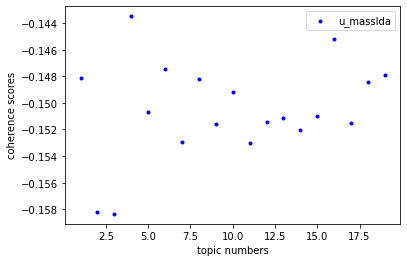

Highest coherence score is obtained when number of topics is  4


In [317]:
num_topics = range(1,20)

## the number of topic words is 100
topic_num = topic_num_selection_coherence(num_topics,model = 'lda',coherence = 'u_mass', num_topic_words=30)

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-7.723562929866338
-7.765673154442973
-7.79533374383237
-7.838422934989584
-7.879335158088468
-7.921850006637444
-7.961532773895778
-7.99948601056313
-8.037730865823338
-8.080457946286353
-8.118724469797934
-8.162667191820457
-8.201920693720574
-8.248768084956525
-8.276808697481258
-8.323672065748646
-8.371711066085151
-8.406386029963612
-8.455980195176718


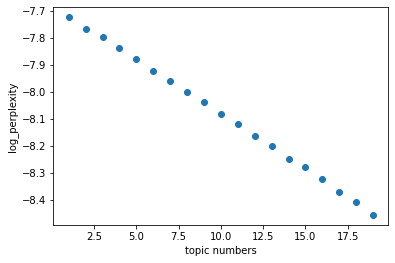

Highest perplexity is obtained when number of topics is  1


1

In [318]:
topic_num_selection_perplexity(num_topics)

In [319]:
## print out the lda performance when topic is 4
lda = LdaModel(corpus  = corpus, num_topics= 4, id2word= dic, alpha = 'auto', eta = 'auto')
lda.print_topics()

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.007*"would" + 0.007*"people" + 0.007*"play" + 0.006*"good" + 0.006*"thing" + 0.006*"look" + 0.005*"say" + 0.005*"know" + 0.005*"want" + 0.005*"time"'),
 (1,
  '0.007*"time" + 0.007*"good" + 0.007*"people" + 0.007*"would" + 0.006*"say" + 0.006*"take" + 0.005*"play" + 0.005*"want" + 0.005*"know" + 0.005*"way"'),
 (2,
  '0.009*"play" + 0.008*"time" + 0.008*"people" + 0.007*"say" + 0.007*"would" + 0.006*"good" + 0.006*"see" + 0.006*"go" + 0.005*"thing" + 0.005*"cyberpunk"'),
 (3,
  '0.007*"see" + 0.007*"would" + 0.007*"people" + 0.007*"look" + 0.006*"time" + 0.006*"good" + 0.006*"play" + 0.006*"go" + 0.006*"know" + 0.006*"say"')]

As we can see, the results for lda model is not good. There are many overlaps between topics. 

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


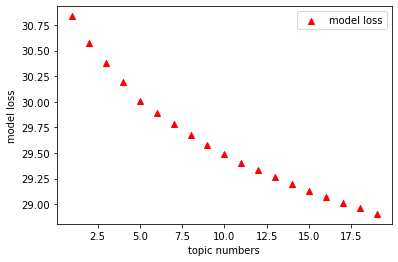

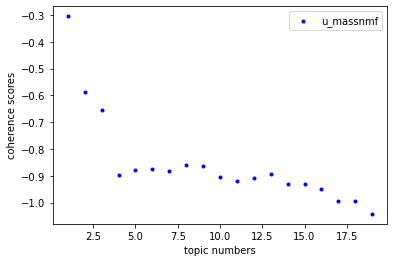

Highest coherence score is obtained when number of topics is  1


1

In [320]:
## topic number selection for NMF model
num_topics = range(1,20)
topic_num_selection_coherence(num_topics , model = 'nmf',coherence = 'u_mass',num_topic_words = 30)

In [321]:
## visualization: use pyldavis
## get the length of each document
def doc_length(text):
    doc_len = np.zeros(len(text))
    i = 0
    for post in text.keys():
        doc_len[i] = len(text[post])
        i += 1
    # print(doc_len.shape)
    return doc_len

def term_freq(corpus,dic):
    tf = np.zeros(len(dic))
    for doc in corpus:
        for w in doc:
            tf[w[0]] += w[1]
    # print(tf.shape)
    return tf

    
def NMF_visualization(model, num_topics, texts = texts, corpus = corpus, dic = dic):
    # print(len(dic))
    ## normalize W and H to make them probability distribution
    W = model.W    
    W = np.divide(W, W.sum(axis = 0).reshape(1,-1))
    # print(W.shape)

    H = model.H
    H = np.divide(H, H.sum(axis = 0).reshape(1,-1))
    # print(H.shape)
    nmf_vis_data = pyLDAvis.prepare(W.transpose(), H.transpose(), doc_length(texts), list(dic.values()), term_freq(corpus,dic))
    file_name = 'nmftopicnumber' + str(num_topics)+ '.html'
    pyLDAvis.save_html(nmf_vis_data, file_name)
    return file_name
    

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [322]:
## topic numbers being 8
nmf8 = NMF_topic_model(num_topics = 8, corpus = corpus, id2word = dic)
nmf8.fit(corpus)
NMF_visualization(nmf8,8)
IPython.display.HTML(filename='/Users/bingjinliu/Desktop/job applications/project/data2/nmftopicnumber8.html')

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [327]:
## printout the topic words, not that the topic labels are different from the labels above.
nmf8.get_topic_words(30)

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'Topic1': ['gen',
  'content',
  'story',
  'issue',
  'developer',
  'lie',
  'gta',
  'marketing',
  'devs',
  'enjoy',
  'people',
  'management',
  'product',
  'reviewer',
  'rpg',
  'launch',
  'development',
  'delay',
  'year',
  'witcher',
  'hype',
  'console',
  'refund',
  'promise',
  'fix',
  'company',
  'bug',
  'cdpr',
  'release'],
 'Topic2': ['bisexual',
  'preference',
  'angel',
  'straight',
  'romantic',
  'takemura',
  'claire',
  'kiss',
  'sexual',
  'sexuality',
  'meredith',
  'scene',
  'relationship',
  'flirt',
  'character',
  'option',
  'voice',
  'gender',
  'woman',
  'girl',
  'lesbian',
  'sex',
  'gay',
  'kerry',
  'river',
  'female',
  'male',
  'romance',
  'judy'],
 'Topic3': ['blurry',
  'high',
  'geforce',
  'reflection',
  'low',
  'console',
  'card',
  'medium',
  'ray',
  'monitor',
  'crash',
  'frame',
  'ssd',
  'graphic',
  'driver',
  'run',
  'nvidia',
  'spec',
  'resolution',
  'ryzen',
  'performance',
  'gtx',
  'ram',
  'ul

## NMF model performance
The larger the topic number is, the more precise the matrix factorization is. But larger topic numbers will make topics less coherent.
By manually check the first 30 top words for each topic under different topic numbers, topic numbers being 8 are good. Because 8 is the largest topic number such that topic divisions make sense. 

Notice that the order of topics shown via pyldavis is by the num of docs under each topic. It is different from the order obtained by NMF.
If the topic number is 9, the topics (in the order of NMF model) are
- 0: about cdpr the company, news about the game
- 1: romance from the game
- 2: high requirement of hardware to play cyberpunk
- 3: driving or cars from the game
- 4: cosplay inspired from the game
- 5: gun, violent elements of the game
- 6: the release of the game on different platforms
- 7: main character and stories of the game


In [324]:
## update the topic results to the posts dataframe, also one column is for loss of the document.

## a and h are column vectors, it returns the 
def loss_rate(x,W,h):
    return norm(x - csc_matrix(np.matmul(W,h).reshape(-1,1)))

    
def update_topics(posts_df, model, num_topics):
    df = posts_df.copy()
    H = model.H
    H = np.divide(H, H.sum(axis = 0).reshape(1,-1))

    i = 0
    for post in posts_df.index:
        for j in range(num_topics):
            df.loc[post, 'topic_' + str(j)] = H[j,i]

        df.loc[post,'loss'] = loss(model.tfidf[:,i], model.W, model.H[:,i])
        i+=1
    return df

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [325]:
update_topics(new_posts_df, nmf8, 8).to_csv('new_posts_8.csv')

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [326]:
new_comments_df.to_csv('new_comments_8.csv')

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Appendix: NMF result for other topic numbers.

In [270]:
## topic numbers being 7
nmf7 = NMF_topic_model(num_topics = 7, corpus = corpus, id2word = dic)
nmf7.fit(corpus)
NMF_visualization(nmf7,7)
IPython.display.HTML(filename='/Users/bingjinliu/Desktop/job applications/project/data2/nmftopicnumber7.html')

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [253]:
## topic numbers being 5
nmf5 = NMF_topic_model(num_topics = 5, corpus = corpus, id2word = dic)
nmf5.fit(corpus)
NMF_visualization(nmf5,5)
IPython.display.HTML(filename='/Users/bingjinliu/Desktop/job applications/project/data2/nmftopicnumber5.html')

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [264]:
nmf5.get_topic_words(20)

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'Topic1': ['people',
  'story',
  'rpg',
  'patch',
  'development',
  'launch',
  'gta',
  'delay',
  'hype',
  'witcher',
  'year',
  'console',
  'promise',
  'fix',
  'refund',
  'company',
  'bug',
  'cdpr',
  'review'],
 'Topic2': ['gender',
  'relationship',
  'woman',
  'takemura',
  'option',
  'jackie',
  'character',
  'voice',
  'girl',
  'lesbian',
  'johnny',
  'sex',
  'gay',
  'kerry',
  'river',
  'female',
  'male',
  'romance',
  'judy'],
 'Topic3': ['driver',
  'run',
  'update',
  'xbox',
  'ryzen',
  'resolution',
  'console',
  'crash',
  'performance',
  'gtx',
  'ram',
  'ultra',
  'download',
  'patch',
  'gpu',
  'rtx',
  'dlss',
  'cpu',
  'setting'],
 'Topic4': ['level',
  'cop',
  'shoot',
  'jump',
  'armor',
  'fight',
  'damage',
  'gun',
  'stealth',
  'drive',
  'hack',
  'craft',
  'kill',
  'enemy',
  'weapon',
  'quest',
  'legendary',
  'perk',
  'mission'],
 'Topic5': ['boob',
  'screenshot',
  'thank',
  'looks',
  'hair',
  'job',
  'pic',
  '

In [268]:
nmf6 = NMF_topic_model(num_topics = 6, corpus = corpus, id2word = dic)
nmf6.fit(corpus)
NMF_visualization(nmf6,6)
nmf6.get_topic_words(20)

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'Topic1': ['product',
  'reviewer',
  'development',
  'patch',
  'story',
  'rpg',
  'launch',
  'delay',
  'year',
  'hype',
  'console',
  'witcher',
  'promise',
  'fix',
  'refund',
  'company',
  'bug',
  'cdpr',
  'review'],
 'Topic2': ['quest',
  'relationship',
  'woman',
  'takemura',
  'option',
  'character',
  'voice',
  'girl',
  'jackie',
  'lesbian',
  'sex',
  'johnny',
  'gay',
  'kerry',
  'river',
  'female',
  'male',
  'romance',
  'judy'],
 'Topic3': ['gog',
  'spec',
  'update',
  'xbox',
  'console',
  'resolution',
  'crash',
  'ryzen',
  'performance',
  'gtx',
  'ram',
  'ultra',
  'download',
  'patch',
  'gpu',
  'rtx',
  'dlss',
  'cpu',
  'setting'],
 'Topic4': ['map',
  'mission',
  'minimap',
  'caliburn',
  'zoom',
  'race',
  'npc',
  'speed',
  'traffic',
  'road',
  'brake',
  'spawn',
  'driving',
  'vehicle',
  'police',
  'cop',
  'bike',
  'gta',
  'drive'],
 'Topic5': ['screenshot',
  'boob',
  'thank',
  'looks',
  'hair',
  'job',
  'pic',


In [269]:
IPython.display.HTML(filename='nmftopicnumber6.html')

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [272]:
## topic numbers being 5
nmf9 = NMF_topic_model(num_topics = 9, corpus = corpus, id2word = dic)
nmf9.fit(corpus)
NMF_visualization(nmf9,9)
IPython.display.HTML(filename='/Users/bingjinliu/Desktop/job applications/project/data2/nmftopicnumber9.html')

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [278]:
nmf9.get_topic_words(20)

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'Topic1': ['lie',
  'marketing',
  'developer',
  'launch',
  'hype',
  'witcher',
  'devs',
  'product',
  'console',
  'delay',
  'management',
  'year',
  'development',
  'bug',
  'fix',
  'promise',
  'refund',
  'company',
  'cdpr'],
 'Topic2': ['meredith',
  'scene',
  'relationship',
  'flirt',
  'character',
  'option',
  'voice',
  'gender',
  'woman',
  'girl',
  'lesbian',
  'sex',
  'gay',
  'kerry',
  'river',
  'female',
  'male',
  'romance',
  'judy'],
 'Topic3': ['crash',
  'frame',
  'graphic',
  'ssd',
  'driver',
  'run',
  'nvidia',
  'spec',
  'resolution',
  'ryzen',
  'performance',
  'gtx',
  'ram',
  'ultra',
  'gpu',
  'rtx',
  'dlss',
  'cpu',
  'setting'],
 'Topic4': ['npc',
  'map',
  'motorcycle',
  'race',
  'minimap',
  'zoom',
  'caliburn',
  'traffic',
  'road',
  'speed',
  'spawn',
  'brake',
  'police',
  'vehicle',
  'cop',
  'driving',
  'bike',
  'gta',
  'drive'],
 'Topic5': ['boob',
  'screenshot',
  'thank',
  'hair',
  'looks',
  'job',
  

 It seems that for nine topics, topic 6 does not make much sense.
 Also, when there are 10 topics, topic 3 and topic 9 seems can be grouped together.

In [274]:
## topic numbers being 5
nmf10 = NMF_topic_model(num_topics = 10, corpus = corpus, id2word = dic)
nmf10.fit(corpus)
NMF_visualization(nmf10,10)
IPython.display.HTML(filename='/Users/bingjinliu/Desktop/job applications/project/data2/nmftopicnumber10.html')

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
